In [73]:
import pandas as pd
import matplotlib.pyplot as plt


import nltk
from nltk import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.pipeline import Pipeline

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/damenac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/damenac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [74]:
data_raw = pd.read_excel('./data/textos.xlsx')
data_raw

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5
...,...,...
9651,Esto implica que el tiempo de las mujeres en e...,5
9652,"Sin embargo, estas fallas del mercado implican...",3
9653,El hecho de hacerlo y cómo hacerlo dependerá e...,9
9654,"Esto se destacó en el primer estudio de caso, ...",6


In [75]:
data_raw.describe()

,ODS
count,9656.000000
mean,7.993993
std,4.692995
min,1.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,16.000000


In [76]:
data_raw.duplicated().sum()

0

In [77]:
data_raw.isna().sum()

textos    0
ODS       0
dtype: int64

In [78]:
x_train = data_raw["textos"]
y_train = data_raw["ODS"]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, train_size=0.8)

### Procesamiento de texto

In [79]:
tokenized = x_train.apply(lambda x: word_tokenize(x))
tokenized

9620    [Esto, puede, lograrse, a, través, de, una, se...
4929    [Los, factores, sociales, y, culturales, son, ...
2302    [Los, centros, de, AEPI, de, calidad, responde...
8184    [Por, ejemplo, ,, en, Australia, ,, se, dispus...
5748    [Es, importante, destacar, que, el, uso, compa...
                              ...                        
5734    [No, más, del, 40, %, de, los, fondos, de, SP,...
5191    [Por, ejemplo, ,, con, el, umbral, de, pobreza...
5390    [Esto, convierte, al, turismo, en, una, indust...
860     [A, través, de, este, proceso, ,, se, crearon,...
7270    [Además, ,, la, red, de, distribución, no, se,...
Name: textos, Length: 7724, dtype: object

In [80]:
tokenizer = RegexpTokenizer(r'\w+')
tokenized_no_punct = x_train.apply(lambda x: tokenizer.tokenize(x))
tokenized_no_punct

9620    [Esto, puede, lograrse, a, través, de, una, se...
4929    [Los, factores, sociales, y, culturales, son, ...
2302    [Los, centros, de, AEPI, de, calidad, responde...
8184    [Por, ejemplo, en, Australia, se, dispuso, de,...
5748    [Es, importante, destacar, que, el, uso, compa...
                              ...                        
5734    [No, más, del, 40, de, los, fondos, de, SP, pu...
5191    [Por, ejemplo, con, el, umbral, de, pobreza, d...
5390    [Esto, convierte, al, turismo, en, una, indust...
860     [A, través, de, este, proceso, se, crearon, do...
7270    [Además, la, red, de, distribución, no, se, ma...
Name: textos, Length: 7724, dtype: object

In [81]:
nltk_stopwords = stopwords.words("spanish")
no_stopwords = tokenized_no_punct.apply(lambda x: [token for token in x if token not in nltk_stopwords])
no_stopwords

9620    [Esto, puede, lograrse, través, serie, medidas...
4929    [Los, factores, sociales, culturales, barrera,...
2302    [Los, centros, AEPI, calidad, responden, natur...
8184    [Por, ejemplo, Australia, dispuso, financiació...
5748    [Es, importante, destacar, uso, compartido, bi...
                              ...                        
5734    [No, 40, fondos, SP, pueden, destinarse, recur...
5191    [Por, ejemplo, umbral, pobreza, definido, 60, ...
5390    [Esto, convierte, turismo, industria, intensiv...
860     [A, través, proceso, crearon, dos, grupos, 1, ...
7270    [Además, red, distribución, mantiene, Alrededo...
Name: textos, Length: 7724, dtype: object

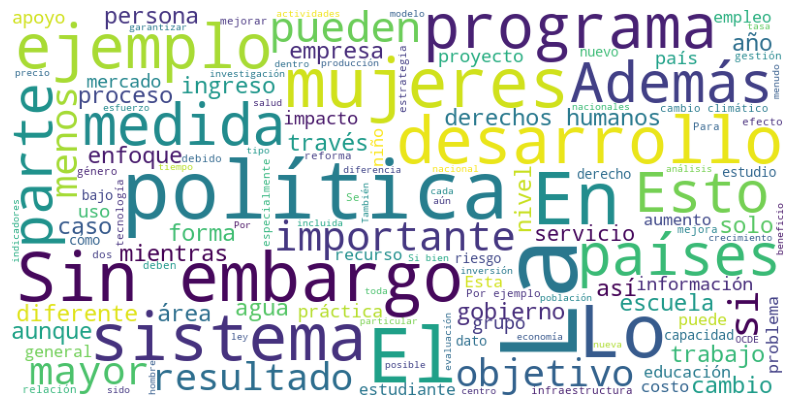

In [82]:
wc_text = ' '.join(word for text in no_stopwords for word in text)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color ='white',
    min_font_size=10,
    max_font_size=110
).generate(wc_text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [83]:
stemmer = PorterStemmer()
stemmed = no_stopwords.apply(lambda x: [stemmer.stem(token) for token in x])
stemmed

9620    [esto, pued, logrars, travé, seri, medida, mej...
4929    [lo, factor, social, cultural, barrera, import...
2302    [lo, centro, aepi, calidad, responden, natural...
8184    [por, ejemplo, australia, dispuso, financiació...
5748    [es, important, destacar, uso, compartido, bic...
                              ...                        
5734    [no, 40, fondo, sp, pueden, destinars, recurso...
5191    [por, ejemplo, umbral, pobreza, definido, 60, ...
5390    [esto, conviert, turismo, industria, intensiva...
860     [a, travé, proceso, crearon, do, grupo, 1, gru...
7270    [ademá, red, distribución, mantien, alrededor,...
Name: textos, Length: 7724, dtype: object

In [84]:
processed = stemmed.apply(lambda x: ' '.join(x))
processed

9620    esto pued logrars travé seri medida mejora pre...
4929    lo factor social cultural barrera important ac...
2302    lo centro aepi calidad responden naturaleza di...
8184    por ejemplo australia dispuso financiación sep...
5748    es important destacar uso compartido bicicleta...
                              ...                        
5734    no 40 fondo sp pueden destinars recurso humano...
5191    por ejemplo umbral pobreza definido 60 ingreso...
5390    esto conviert turismo industria intensiva coor...
860     a travé proceso crearon do grupo 1 grupo trata...
7270    ademá red distribución mantien alrededor 27 1 ...
Name: textos, Length: 7724, dtype: object

In [85]:
vectorizer = CountVectorizer()
data = vectorizer.fit_transform(processed)
data

<7724x26859 sparse matrix of type '<class 'numpy.int64'>'
	with 401285 stored elements in Compressed Sparse Row format>

In [86]:
y_train

9620     7
4929     5
2302     4
8184     3
5748    11
        ..
5734     3
5191     1
5390    12
860      8
7270     6
Name: ODS, Length: 7724, dtype: int64

In [87]:
tsvd = TruncatedSVD(n_components=100)

#model = LogisticRegression(max_iter=500)
#model = MLPClassifier(hidden_layer_sizes=(15),max_iter=400, random_state=42, solver='lbfgs')
#model = SVC(kernel='linear', C=10)
#model = SVC(kernel='rbf', C=0.9)
model = RandomForestClassifier(max_depth=500, random_state=42)

steps = [
    ("vectorizer", vectorizer),
    ("dimred", tsvd),
    ("model", model),
]

pipeline = Pipeline(steps)
pipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('dimred', TruncatedSVD(n_components=100)),
                ('model',
                 RandomForestClassifier(max_depth=500, random_state=42))])

In [88]:
y_pred = pipeline.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.70      0.73        90
           2       0.53      0.28      0.37        71
           3       0.59      0.74      0.66       178
           4       0.68      0.87      0.76       200
           5       0.73      0.82      0.77       232
           6       0.83      0.83      0.83       135
           7       0.66      0.77      0.71       164
           8       0.47      0.28      0.35        86
           9       0.27      0.18      0.22        55
          10       0.45      0.28      0.35        60
          11       0.48      0.43      0.45       143
          12       0.51      0.41      0.45        64
          13       0.73      0.60      0.66       102
          14       0.47      0.38      0.42        64
          15       0.76      0.36      0.49        81
          16       0.72      0.91      0.80       207

    accuracy                           0.65      1932
   macro avg       0.60   

In [89]:
ods = pd.DataFrame(data=['No poverty', 'Zero hunger', 'Good health and well-being', 'Quality education', 'Gender equality', 'Clean water and sanitation',
                         'Affordable and clean energy', 'Decent work and economic growth', 'Industry, innovation, and infrastructure', 'Reduced inequalities',
                         'Sustainable cities and communities', 'Reponsible consumption and production','Climate action', 'Life below water', 'Life an land', 'Peace, justice and strong institutions',
                         'Partnerships for the goals'])


In [90]:
def predecir(texto=None):
    serie_prueba = pd.Series(data=[texto])
    prediccion_prueba = pipeline.predict(serie_prueba)
    resultado = ods.iloc[prediccion_prueba[0]-1,0]
    return resultado

In [91]:
texto = 'Garantizar acceso al agua potable a la población vulnerable en los barrios del sur de Bogotá'
predecir(texto=texto)

'Clean water and sanitation'